In [3]:
#export
library("tidyverse")
library("survival")
library("survminer")
library("patchwork") # subplots
library("repr") #resize plots
library("IRdisplay") #display images
library("ggthemes")
source("00_functions.R")

In [4]:
#export
options(warn=-1)
options(repr.plot.width=14, repr.plot.height=10)
data_path ="../data/"

## Helper functions

In [162]:
normalize_surv_time = function(t, t_norm, t_thresh){ifelse(t/t_norm < t_thresh, t/t_norm, t_thresh)}

## Load data from the platform

In [163]:
df = readRDS("../../platform/database/platform.rds")

In [164]:
print(df)

# A tibble: 22 x 3
   dataset      clinical_data            expression_data              
   <chr>        <list>                   <list>                       
 1 ExprImageRaw <df[,134] [311 × 134]>   <df[,134] [311 × 134]>       
 2 ExprImageFil <df[,134] [152 × 134]>   <df[,134] [152 × 134]>       
 3 METABRIC     <df[,52] [2,136 × 52]>   <df[,48803] [2,136 × 48,803]>
 4 GSE11121     <df[,64] [200 × 64]>     <df[,12403] [200 × 12,403]>  
 5 GSE19615     <df[,78] [115 × 78]>     <df[,20175] [115 × 20,175]>  
 6 GSE22226A    <df[,31] [129 × 31]>     <df[,41000] [129 × 41,000]>  
 7 GSE22226B    <df[,31] [20 × 31]>      <df[,41000] [20 × 41,000]>   
 8 GSE26971     <df[,94] [146 × 94]>     <df[,12400] [146 × 12,400]>  
 9 GSE96058     <df[,113] [3,273 × 113]> <df[,30865] [3,273 × 30,865]>
10 GSE1456A     <df[,63] [159 × 63]>     <df[,12400] [159 × 12,400]>  
# … with 12 more rows


#### Combine expression data for GSE9922, use the Uppsala cohort only

In [165]:
inds = which(GSE4922.clin$description=='Series of 249 tumours')
C = df$clinical_data[[which(df$dataset=="GSE4922A")]][inds,]
E.a = df$expression_data[[which(df$dataset=="GSE4922A")]]
E.b = df$expression_data[[which(df$dataset=="GSE4922B")]]
E = bind_cols(E.a[inds,],E.b[inds,])
dim(C)
dim(E)

New names:
* A1CF -> A1CF...1
* AAGAB -> AAGAB...8
* AAK1 -> AAK1...9
* AASDHPPT -> AASDHPPT...15
* ABCA5 -> ABCA5...26
* ...



[1] 249  81

[1]   249 22235

In [166]:
df = df %>% add_row(tibble_row(dataset = "GSE4922", clinical_data = list(C), expression_data = list(E)))

## Select Datasets 

In [169]:
dataset_names = c("METABRIC", "TCGA", "GSE11121", "GSE96058", "GSE7390", "GSE9893", "NKI", "GSE4922")
data = df %>% filter(dataset %in% dataset_names)
print(data)

# A tibble: 8 x 3
  dataset  clinical_data            expression_data              
  <chr>    <list>                   <list>                       
1 METABRIC <df[,52] [2,136 × 52]>   <df[,48803] [2,136 × 48,803]>
2 GSE11121 <df[,64] [200 × 64]>     <df[,12403] [200 × 12,403]>  
3 GSE96058 <df[,113] [3,273 × 113]> <df[,30865] [3,273 × 30,865]>
4 GSE7390  <df[,103] [198 × 103]>   <df[,12403] [198 × 12,403]>  
5 GSE9893  <df[,85] [155 × 85]>     <df[,7384] [155 × 7,384]>    
6 NKI      <df[,36] [337 × 36]>     <df[,24481] [337 × 24,481]>  
7 TCGA     <df[,110] [1,096 × 110]> <df[,38139] [1,096 × 38,139]>
8 GSE4922  <df[,81] [249 × 81]>     <df[,22235] [249 × 22,235]>  


### Filter gene expressions and fix gene expression names for METABRIC 

In [170]:
i = which(data$dataset=="METABRIC")
data$expression_data[[i]] = filter_and_annotate_mb(data$expression_data[[i]])
data$expression_data[[i]][1:5,1:5]

,EEF1A1,GAPDH,SLC35E2A,EFCAB1,RPS28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
251,10.57853,12.24909,5.683049,5.598732,12.59326
237,10.44290,12.88604,5.432453,5.471187,12.89320
274,10.75033,11.13193,5.610684,5.335402,12.84924
427,10.50070,11.14201,5.622907,5.520060,12.76226
111,10.48836,12.29533,5.527243,5.444097,12.38603


In [171]:
dfs = map2(data$clinical_data, data$expression_data, bind_cols)

New names:
* NA -> ...39

New names:
* A1CF...1 -> A1CF...82
* AAGAB...8 -> AAGAB...89
* AAK1...9 -> AAK1...90
* AASDHPPT...15 -> AASDHPPT...96
* ABCA5...26 -> ABCA5...107
* ...



In [173]:
names(dfs) = data$dataset

#### Checkpoint

In [175]:
saveRDS(dfs, paste(data_path,"dfs.rds"))

In [7]:
dfs = readRDS(paste(data_path,"dfs.rds"))

### Check estrogen expression in selected datasets

In [177]:
p = map2(data$expression_data, data$dataset, function(x,y) ggplot(x,aes(x=ESR1)) + 
        geom_histogram(bins=40,  fill="lightblue", color="#9999ff") + 
        theme_classic() + 
        ggtitle(y))

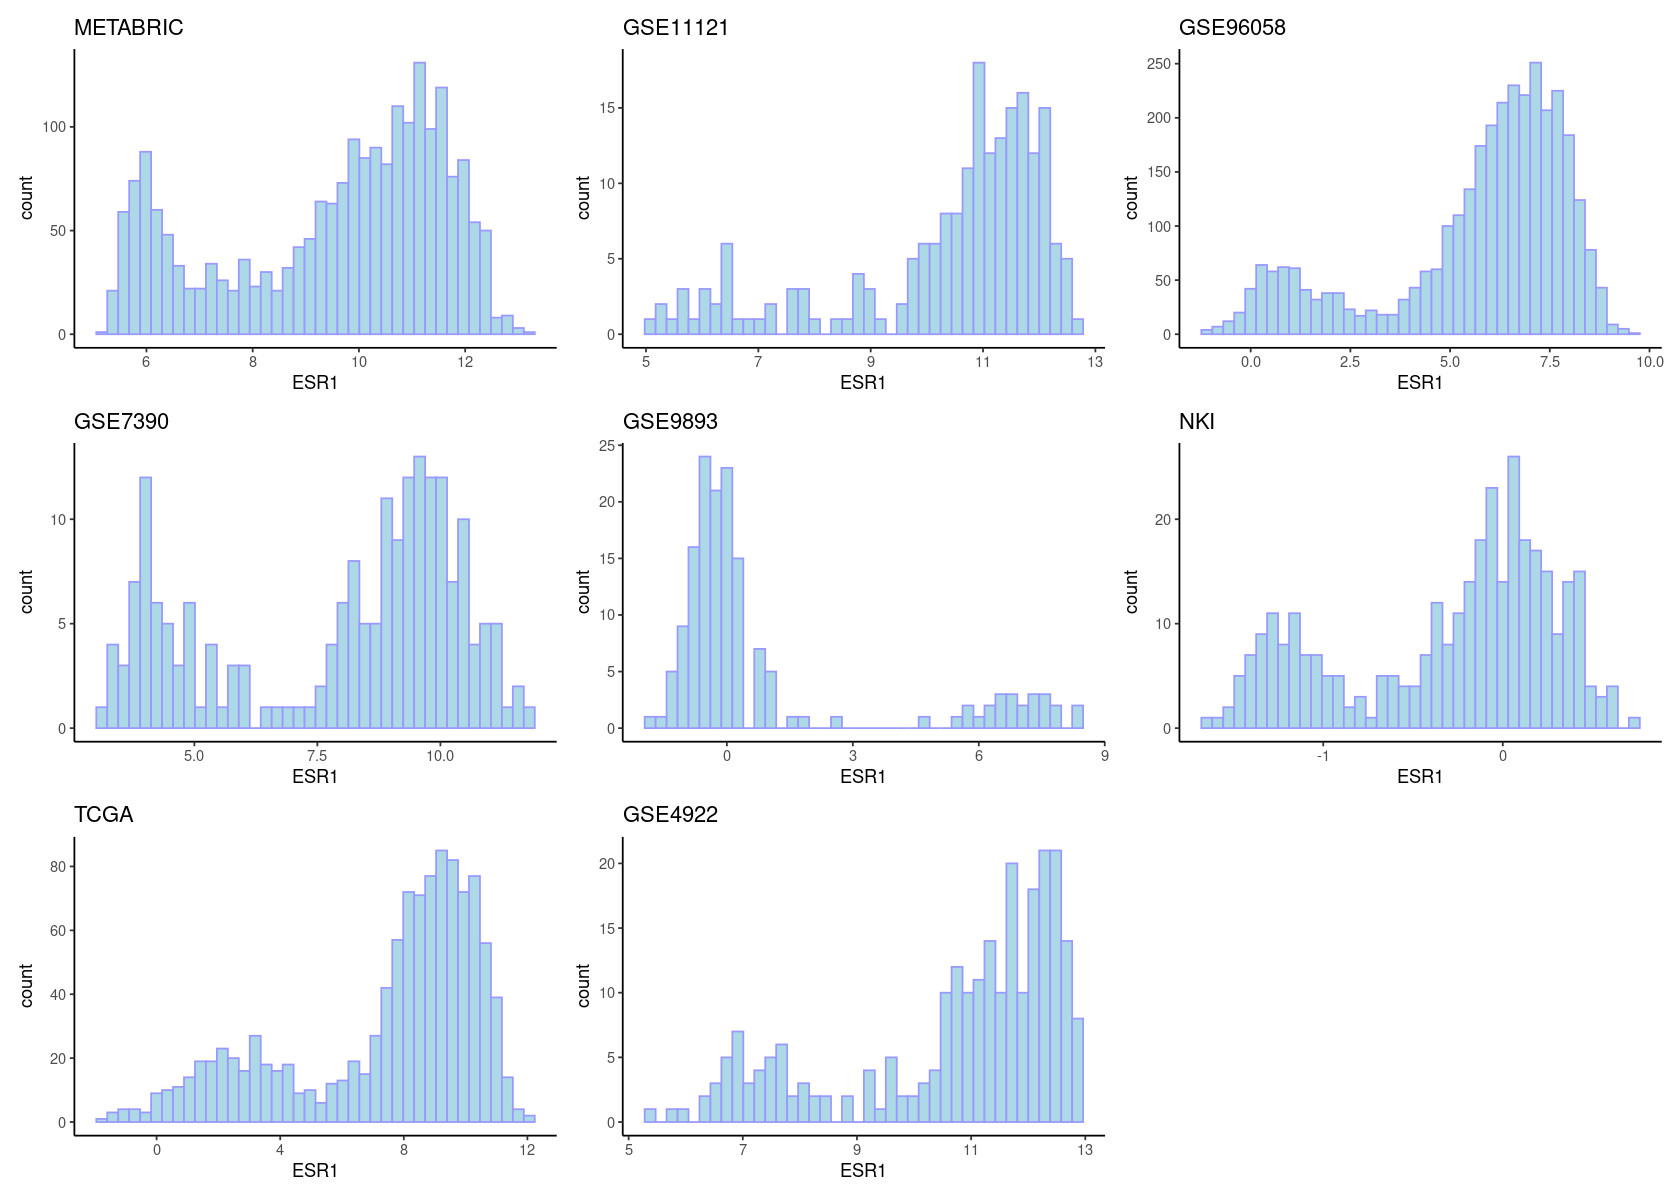

In [178]:
p[[1]]+p[[2]]+p[[3]]+p[[4]]+p[[5]]+p[[6]]+p[[7]]+p[[8]] 

## Select estrogen receptor positive patients without chemo-therapy under age 70

In [179]:
age_thresh = 70
stime_long = 10 #survival time in years
stime_short = 5
time_norm = 12 # 12 converts months to years

### METABRIC

In [180]:
i = which(data$dataset=="METABRIC")
dfs[[i]] = dfs[[i]] %>% 
  filter(ER.Status=="Positive", 
         Chemotherapy=="NO", 
         Age.at.Diagnosis<=age_thresh,
         Patient.s.Vital.Status=="Died of Disease" | Patient.s.Vital.Status=="Living") %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(Patient.s.Vital.Status=="Living" | survival_time==stime_long, 0, 1))

In [181]:
table(dfs[[i]]$event)


  0   1 
519 164 

### GSE11121 aka MAINZ collective
* These are already no chemo patients
* Distant Metastasis Free Survival within 10 years

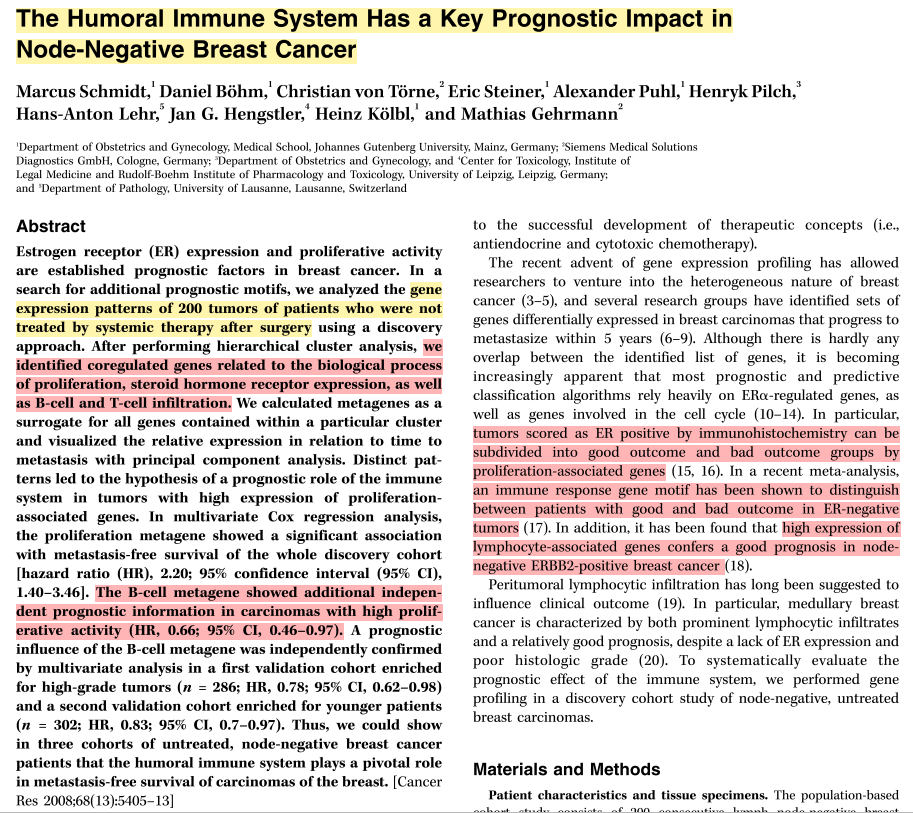

In [182]:
display_png(file="../images/GSE11121.png")  

In [183]:
i = which(data$dataset=="GSE11121")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )

In [184]:
table(dfs[[i]]$event)


 0  1 
97 23 

### GSE96058 aka SCAN-B

* Overall survival within 5 years

In [185]:
i = which(data$dataset=="GSE96058")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh,
        chemo==0) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_short),
         event = ifelse(event==0 | survival_time==stime_short, 0, 1)
         )

In [186]:
table(dfs[[i]]$event)


   0    1 
1053   49 

### GSE7390 aka TRANSBIG

* Distant metastasis free surivival within 10 years

Purpose: Recently, a 76-gene prognostic signature able to predict distant metastases in lymph node ^ negative (N-) breast cancer patients was reported. The aims of this study conducted by TRANSBIGwere to independently validate these results and to compare the outcomewithclinical risk assessment. 

Experimental Design: Gene expression profiling of frozen samples from 198 N- systemically untreated patients was done at the Bordet Institute, blinded to clinical data and independent of Veridex. Genomic risk was defined byVeridex, blinded to clinical data. Survival analyses, done by an independent statistician, were done with the genomic risk and adjusted for the clinical risk, defined byAdjuvant! Online. 

Results: The actual 5-and 10-year time to distant metastasis were 98% (88-100%) and 94% (83-98%), respectively, for the good profile group and 76% (68-82%) and 73% (65-79%), respectively, for the poor profile group. The actual 5-and 10-year overall survival were 98% (88-100%) and 87% (73-94%), respectively, for the good profile group and 84% (77-89%) and 72% (63-78%), respectively, for the poor profile group.We observed a strong time depen- dence of this signature, leading to an adjusted hazard ratio of 13.58 (1.85-99.63) and 8.20 (1.10-60.90) at 5years and5.11(1.57-16.67) and 2.55 (1.07-6.10)at 10years for time to distant metastasis and overall survival, respectively. Conclusion: This independent validation confirmed the performance of the 76-gene signature and adds to the growing evidence that gene expression signatures are of clinical relevance, especially for identifying patients at high risk of early distant metastases.

In [187]:
i = which(data$dataset=="GSE7390")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh,
         chemo==0) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )
table(dfs[[i]]$event)


  0   1 
108  26 

### GSE9893 aka a 36-gene signature

* Metastasis free survival within 10 years

Purpose: The identification of a molecular signature predicting the relapse of tamoxifen-treated primary breast cancers should help the therapeutic management of estrogen receptor ^ positive cancers. 

Experimental Design: A series of 132 primary tumors from patients who received adjuvant tamoxifen were analyzed for expression profiles at the whole-genome level by 70-mer oligonu- cleotide microarrays. A supervised analysis was done to identify an expression signature. 

Results:We defined a 36-gene signature that correctly classified 78% of patients with relapse and 80% of relapse-free patients (79% accuracy). Using 23 independent tumors, we confirmed the accuracy of the signature (78%) whose relevance was further shown by using published microarray data from 60 tamoxifen-treated patients (63% accuracy). Univariate analysis using the validation set of 83 tumors showed that the 36-gene classifier is more efficient in predicting disease-free survival than the traditional histopathologic prognostic factors and is as effective as the Nottingham Prognostic Index or the ‘‘Adjuvant!’’ software. Multivariate analysis showed that the molecular signature is the only independent prognostic factor. A comparison with several already published signatures demonstrated that the 36-gene signature is among the best to classify tumors from both training and validation sets. Kaplan-Meier analyses emphasized its prognostic power both on the whole cohort of patients and on a subgroup with an intermediate risk of recurrence as defined by the St. Gallen criteria. 

Conclusion: This study identifies a molecular signature specifying a subgroup of patients who do not gain benefits from tamoxifen treatment. These patients may therefore be eligible for alternative endocrine therapies and/or chemotherapy.
Breast

In [188]:
i = which(data$dataset=="GSE9893")
dfs[[i]] = dfs[[i]] %>%
  filter(ER!='ER <10', #All but eight tissue specimens were ER+, and six of the eight ER- tumors were PR+.
         age<=age_thresh,
         chemo==0) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )
table(dfs[[i]]$event)


 0  1 
57 29 

### NKI aka 70-gene signature

* Recurrence free survival within 10 years

#### Gene expression profiling predicts clinical outcome of breast cancer Laura J. van 't Veer
#### A GENE-EXPRESSION SIGNATURE AS A PREDICTOR OF SURVIVAL IN BREAST CANCER M ARC J. VAN DE V IJVER 

In [189]:
i = which(data$dataset=="NKI")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh,
         chemo==0) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )
table(dfs[[i]]$event)


  0   1 
123  52 

### TCGA

* Overall survival within 10 years

In [190]:
i = which(data$dataset=="TCGA")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh,
         chemo==0) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )
table(dfs[[i]]$event)


  0   1 
152  17 

### GSE4922 aka Uppsala cohort

* DFS EVENT (0=censored; 1=event defined as any type of recurrence (local, regional or distant) or death from breast cancer within 10 years

Genetic Reclassification of Histologic Grade Delineates New Clinical Subtypes of Breast Cancer

Histological grading of breast cancer defines morphological subtypes informative of metastatic potential, although not without considerable inter-observer disagreement and clinical heterogeneity particularly among the moderately differentiated grade II (G2) tumors. We posited that a gene expression signature capable of discerning tumors of grade I (G1) and grade III (G3) histology might provide a more objective measure of grade with prognostic benefit for patients with moderately differentiated disease. To this end, we studied the expression profiles of 347 primary invasive breast tumors analyzed on Affymetrix microarrays. Using class prediction algorithms, we identified 264 robust grade-associated markers, six of which could accurately classify G1 and G3 tumors, and separate G2 tumors into two highly discriminant classes (termed G2a and G2b genetic grades) with patient survival outcomes highly similar to those with G1 and G3 histology, respectively. Statistical analysis of conventional clinical variables further distinguished G2a and G2b subtypes from each other, but also from histologic G1 and G3 tumors. In multivariate analyses, genetic grade was consistently found to be an independent prognostic indicator of disease recurrence comparable to that of lymph node status and tumor size. When incorporated into the Nottingham Prognostic Index, genetic grade enhanced detection of patients with less harmful tumors, likely to benefit little from adjuvant therapy. Our findings show that a genetic grade signature can improve prognosis and therapeutic planning for breast cancer patients, and support the view that low and high grade disease, as defined genetically, reflect independent pathobiological entities rather than a continuum of cancer progression. Three separate breast cancer cohorts were analyzed: 1) Uppsala (n=249), 2) Stockholm (n=58), 3) Singapore (n=40). The Uppsala and Singapore data can be accessed here. 

In [191]:
i = which(data$dataset=="GSE4922")
dfs[[i]] = dfs[[i]] %>%
  filter(ER==1, 
         age<=age_thresh,
         dfs[[i]]$"No systemic therapy (1=included in survival analysis)"==1
        ) %>%
  mutate(survival_time = normalize_surv_time(survival_time, time_norm, stime_long),
         event = ifelse(event==0 | survival_time==stime_long, 0, 1)
         )
table(dfs[[i]]$event)


 0  1 
54 26 

### Check ESR1 

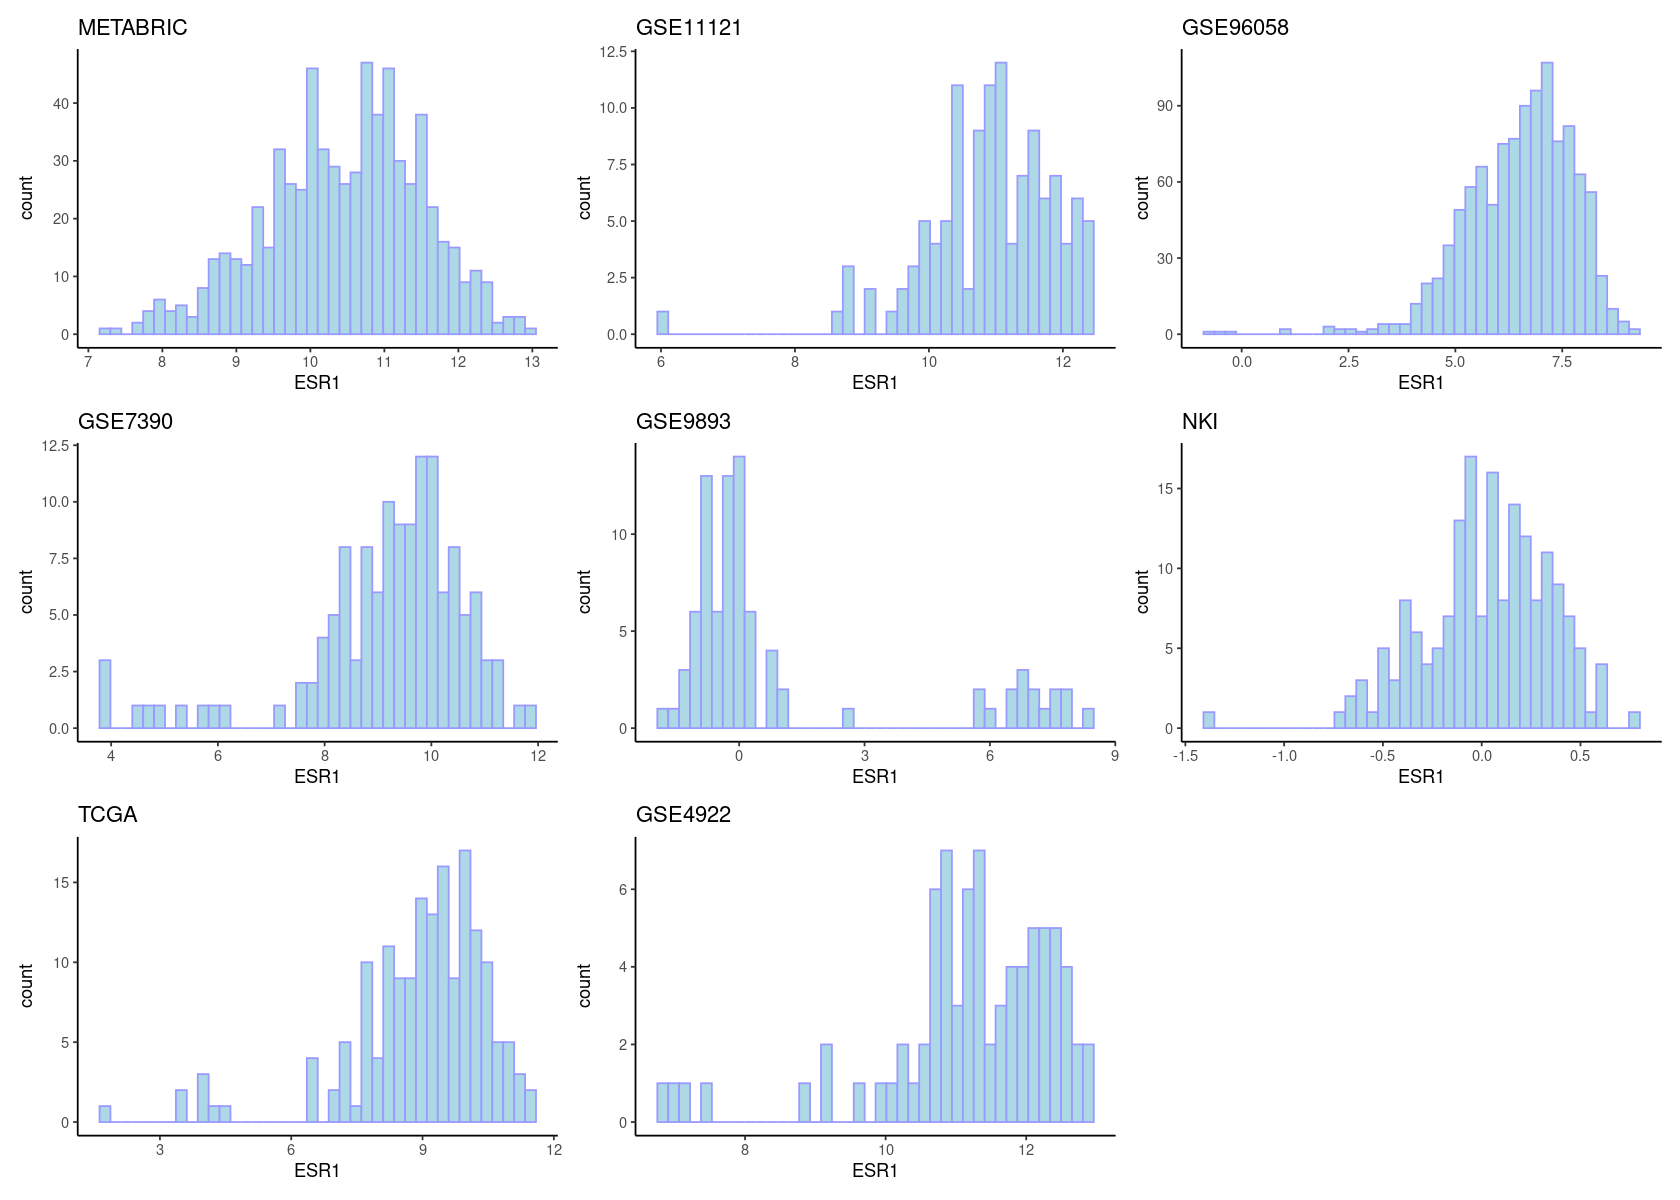

In [192]:
p = map2(dfs, data$dataset, function(x,y) ggplot(x,aes(x=ESR1)) + 
        geom_histogram(bins=40,  fill="lightblue", color="#9999ff") + 
        theme_classic() + 
        ggtitle(y))

p[[1]]+p[[2]]+p[[3]]+p[[4]]+p[[5]]+p[[6]]+p[[7]]+p[[8]]

In [193]:
X = do.call(rbind.data.frame,
            map(1:length(dfs), function(i){c(data$dataset[i], dim(dfs[[i]])[1], table(dfs[[i]]$event))}))
colnames(X) = c("Dataset", "Patients", "Event", "Control")
X

Dataset,Patients,Event,Control
<chr>,<chr>,<chr>,<chr>
METABRIC,683,519,164
GSE11121,120,97,23
GSE96058,1102,1053,49
GSE7390,134,108,26
GSE9893,86,57,29
NKI,179,123,52
TCGA,169,152,17
GSE4922,80,54,26


## Correct gene names for Cox model

In [42]:
#export
first_expr_col = function(df){
    first_genes = c("A1CF", "A1BG", "LOC400451", "5_8S_rRNA", "MAPK3", "RRM1", "GREM2", 
                    "TSPAN6", "EEF1A1", "A1CF_82", "A1CF...82", "A1CF82")
    for (i in 1:200){if(is.numeric(df[,i])  & names(df)[i] %in% first_genes){return(i)}}
} 

In [5]:
#export
correct_gene_names = function(x){
    x = gsub("...", "_", x, fixed=TRUE)
    x = gsub("-", "_", x, fixed=TRUE)
    x = gsub("@", "_", x, fixed=TRUE)
    x = gsub(" ", "_", x, fixed=TRUE)
    x = gsub(".", "_", x, fixed=TRUE)
    x =  sub("[\\s_]+", "", x, perl=TRUE)
    x
}

In [47]:
#export
substitute = partial(gsub, replacement = "_", fixed=TRUE)

In [80]:
correct_gene_names_in_df = function(df){
    names(df)[first_expr_col(df):dim(df)[2]] = correct_gene_names(names(df)[first_expr_col(df):dim(df)[2]])
    df
}

In [81]:
dfs = readRDS(paste(data_path,"dfs_filtered.rds"))

In [82]:
dfs = map(dfs, correct_gene_names_in_df)

### Remove columns with NAs

In [74]:
remove_na = function(df) {
    df = df[!is.na(names(df))]
    df[colSums(!is.na(df)) > 0]
}

In [75]:
dfs = map(dfs, remove_na)

## Save data

In [83]:
saveRDS(dfs, paste(data_path,"dfs_filtered.rds"))

## Export code

In [44]:
system("python3 notebook2script.py 01_data_preparation.ipynb")